# **GIS × Python Tutorial Session 8 ~ 点群データからオルソ画像を作成 ~**
---
この記事は「GIS × Python Tutorial」の関連記事です。

<br><br><br>

## **はじめに**
---
前回の記事では CSF（Cloth Simulation Filter） による点群分類と DTM（Digital Terrain Model） の作成を行いました。今回は DTM の後処理を行う予定でしたが、結構長くなりそうだったので、今回は点群データからオルソ画像を作成する方法について解説していきます。

 - オルソ画像とは
 
 - PDALで点群データからオルソ画像を生成する

 - rasterio

 - rasterioでのデータ読み込み

 - バンド合成

 - 様々なバンドの組み合わせ

 - rasterioでのデータ出力





## **今回使用するデータ**
---
今回は Session6 の記事で作成した '.las' を使用します。元々はオープンナガサキからダウンロードした点群データです。
<br><br><br>

<br><br><br>
## **インポート**
---

In [169]:
import json

from IPython.display import Image
import japanize_matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pdal
import pyproj
import rasterio
import rasterio.mask
import rasterio.plot
import shapely
from shapely.plotting import plot_polygon
japanize_matplotlib.japanize()


IN_FILE = r'../datasets/01ID7913_proj.las'
# 静岡県のEPSGコード
IN_EPSG = 'EPSG:6669'
proj_crs = pyproj.CRS(IN_EPSG)
IN_SRS = proj_crs.to_wkt(pretty=True)

## **オルソ画像とは**
---
**オルソ画像** とは上空から撮影した画像を正射変換し、真上から見たような傾きの無い、正しい大きさと位置に表示される様に変換した画像の事です。

上空の遠く離れた場所から大きな範囲を撮影した画像は、画像の端に行くほどに、写真に映る物体が大きく斜めに傾いて映っています。

オルソ画像を作成する場合の撮影は、以下の①の様に一意な範囲を撮影するのではなく、②の様に同じ場所が複数の写真に映るように撮影します。その画像を合成する事でオルソ画像を作成します。

進行方向に重なっている範囲を'オーバーラップ率'、折り返しなどで別なコースの写真と重なっている範囲を'サイドラップ率'と呼びます。

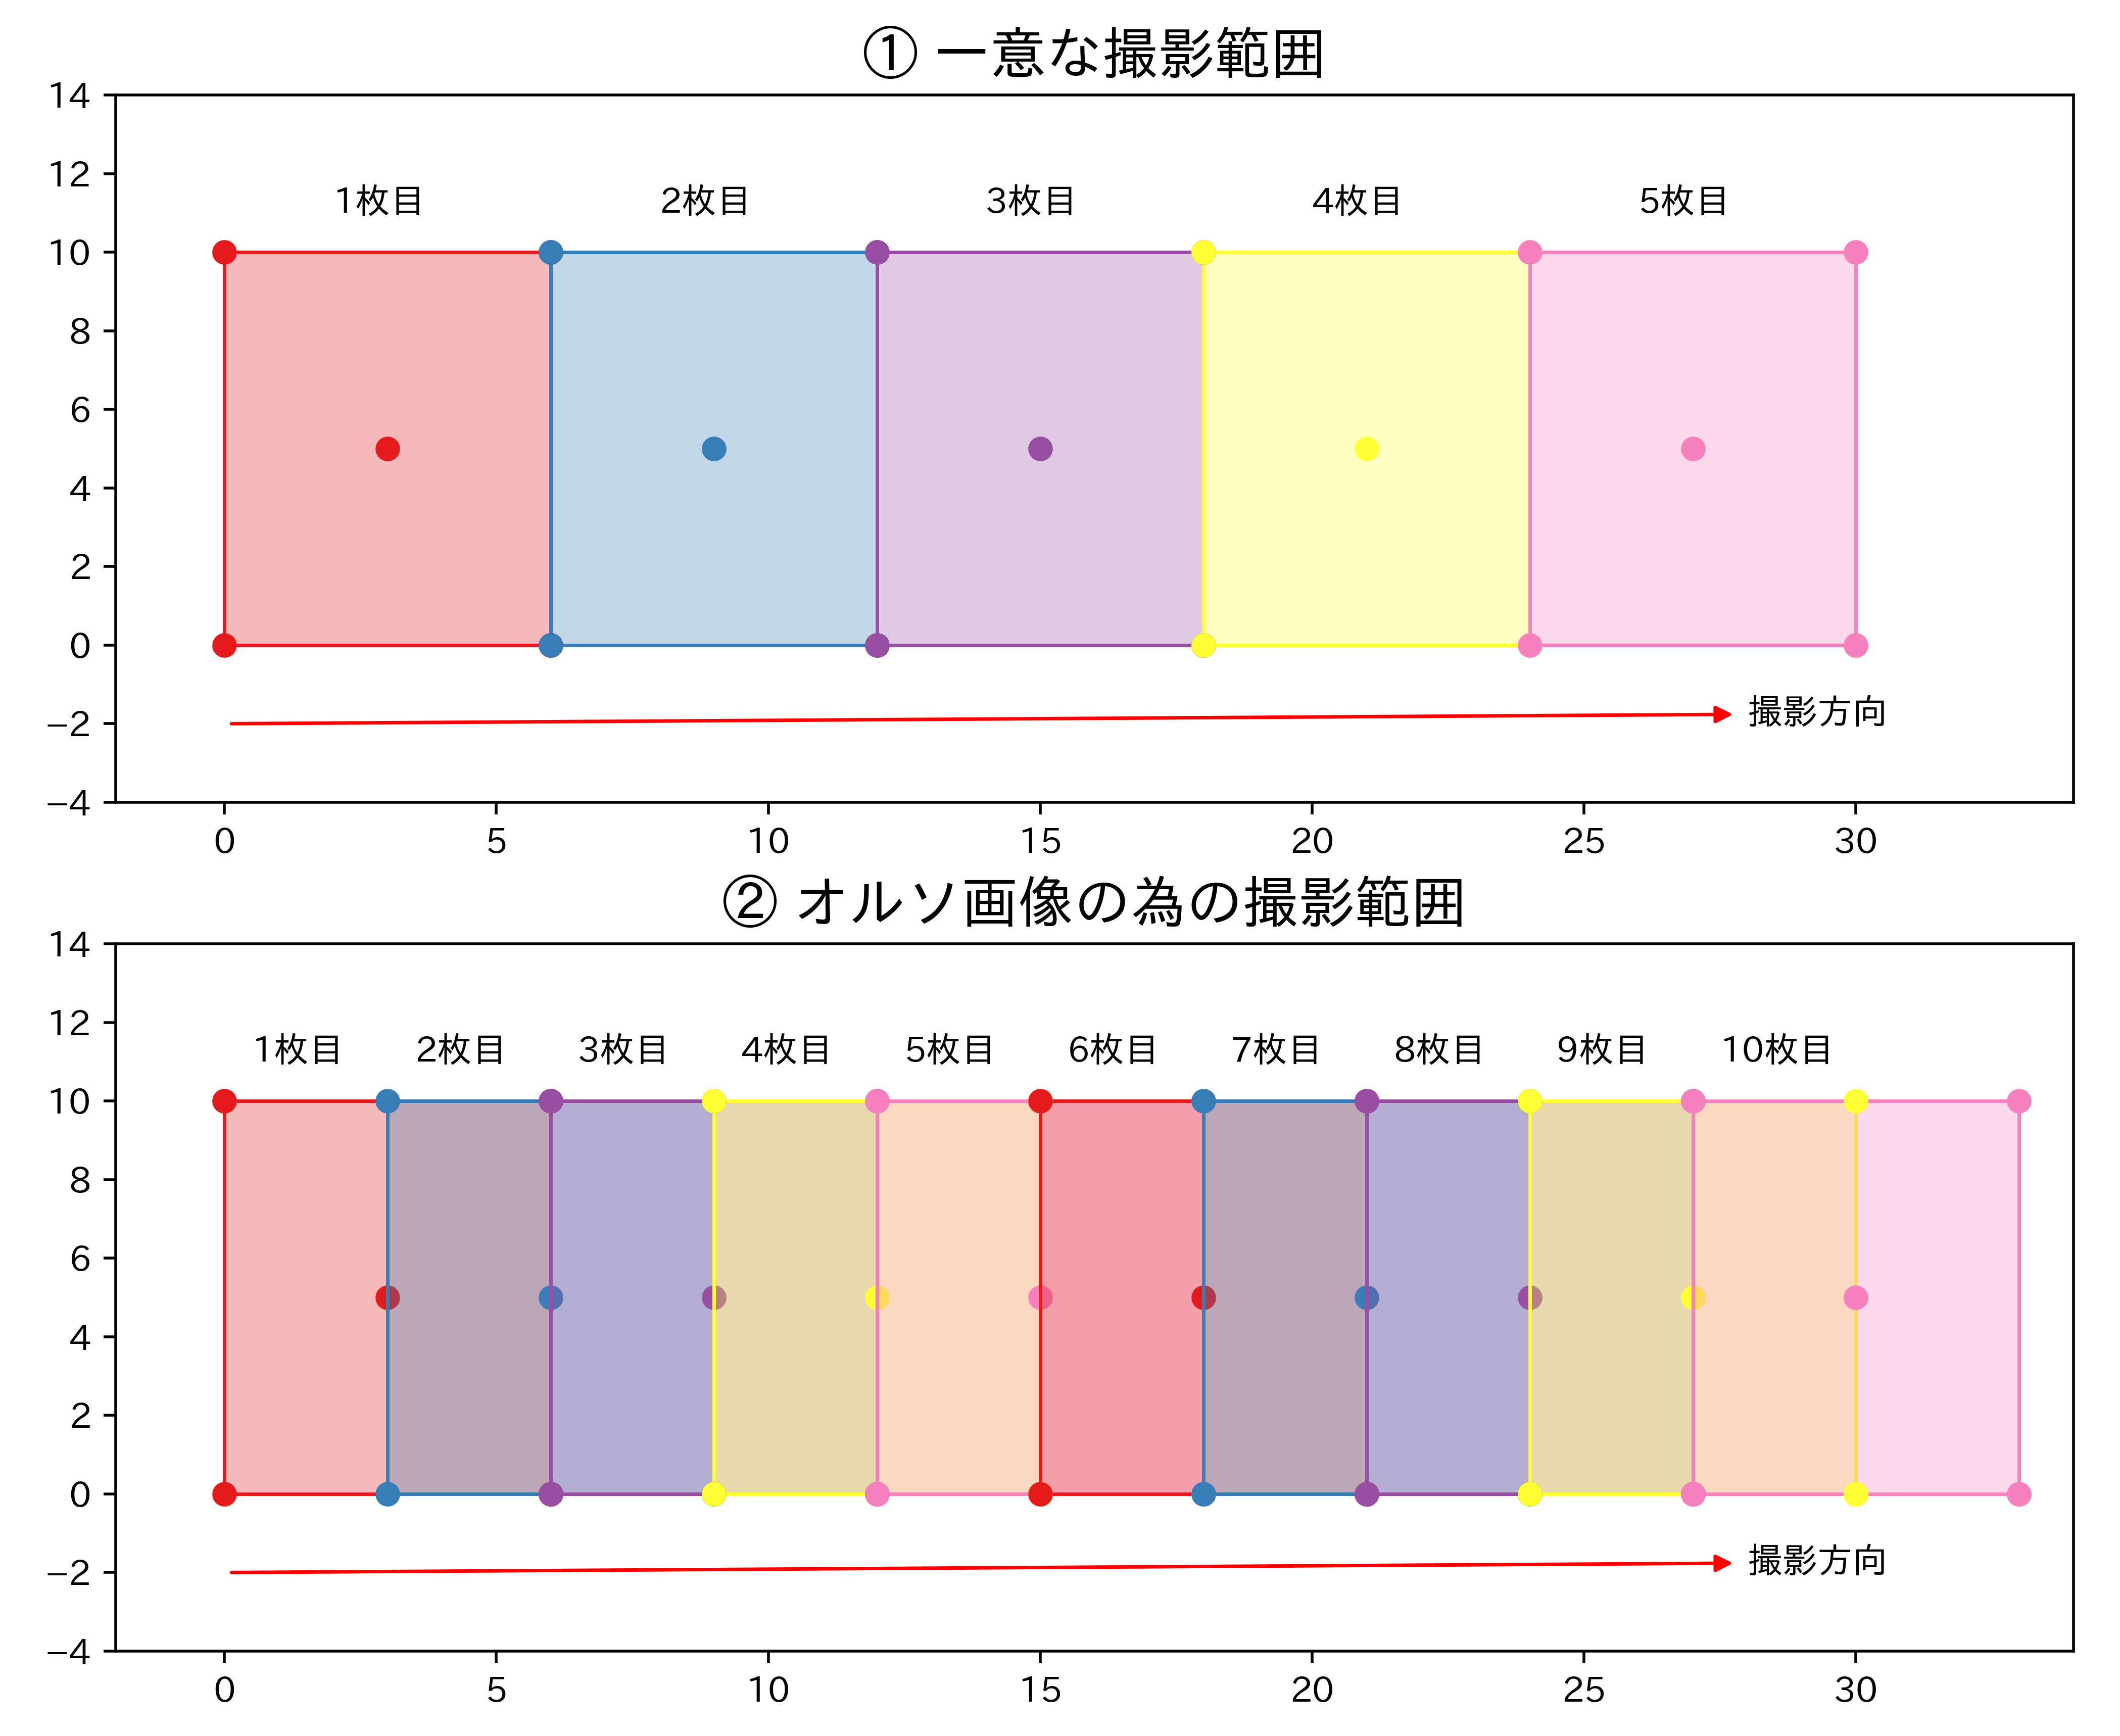

In [2]:

Image(r'../images/image_of_photographing.png', width=800)

In [3]:

Image(url='https://upload.wikimedia.org/wikipedia/commons/7/7b/%E5%9B%BD%E5%9C%9F%E5%9C%B0%E7%90%86%E9%99%A2_%E3%82%AA%E3%83%AB%E3%82%BD%E7%94%BB%E5%83%8F.jpg', width=800)

[出典：国土地理院ウェブサイト](https://www.gsi.go.jp/gazochosa/gazochosa40002.html)

## **PDAL で点群データからオルソ画像を作成する**
---
PDAL で点群データからトゥルーオルソ画像を作成するのは非常に簡単です。但しこれは点群データに RGB の情報が入力されている場合に限ります。

以前の記事でも見ましたが、まずは「点群データ（.las）にどんな情報が入力されているのか」を確かめてみましょう。

以前の記事では、Dict の中に Pipeline の処理を書いて、JSON 文字列化して処理を実行しました。今回は別な書き方をしてみます。オブジェクト指向に慣れた方であれば、こちらの方が分かりやすいかもしれません。

### **有用な要素の確認**
点群データの中から使用できそうな要素を確認します。要素の種類自体は多くありますが、実際に使用可能な要素は多くありません。pandas.DataFrame の形に変換し、不要な列を削除します。

In [5]:
readers = pdal.Reader.las(IN_FILE)
pipeline = readers.pipeline()
pipeline.execute()
df = pipeline.get_dataframe(0)


del_cols = []
for col in df.columns:
    if len(df[col].unique()) == 1:
        del_cols.append(col)

df.drop(del_cols, axis=1).describe()

X             Y             Z     Intensity           Red  \
count  6.684581e+06  6.684581e+06  6.684581e+06  6.684581e+06  6.684581e+06   
mean  -3.484883e+03  3.786842e+04  3.154098e+02  1.676435e+02  2.039356e+04   
std    2.881643e+02  2.167067e+02  6.870297e+01  6.171454e+01  8.347706e+03   
min   -4.000000e+03  3.750000e+04  1.428500e+02  0.000000e+00  5.140000e+02   
25%   -3.731850e+03  3.768077e+04  2.672600e+02  1.340000e+02  1.310700e+04   
50%   -3.475220e+03  3.786558e+04  2.959000e+02  1.790000e+02  1.927500e+04   
75%   -3.233750e+03  3.805521e+04  3.566900e+02  2.120000e+02  2.698500e+04   
max   -3.000000e+03  3.825000e+04  5.196200e+02  2.550000e+02  6.553500e+04   

              Green          Blue  
count  6.684581e+06  6.684581e+06  
mean   2.492939e+04  2.461110e+04  
std    6.574588e+03  5.020807e+03  
min    7.196000e+03  1.799000e+03  
25%    1.927500e+04  2.081700e+04  
50%    2.415800e+04  2.364400e+04  
75%    2.981200e+04  2.775600e+04  
max    6.553500e+04  6.553500e+04

画像の作成に使用出来そうな値は、**「Intensity（反射強度）」「Red」「Green」「Blue」** の4種類ですね。

### **地上解像度の設定をどうするか**

まずはパラメーターを設定します。地上解像度は単純にセルの大きさの事です。このセルの範囲に含まれる点群の要素を計算して、画像を作成するのでこの大きさを考えるのは重要なタスクです。1平方メートルあたり、何点計測されているのかを見てみましょう。

In [6]:
# メタデータから、計測範囲の座標を取り出す
metadata = pipeline.metadata.get('metadata').get('readers.las')
x_max, y_max = metadata.get('maxx'), metadata.get('maxy')
x_min, y_min = metadata.get('minx'), metadata.get('miny')

# shapely.Polygonのオブジェクトを作成し、面積を計算する
area = shapely.box(x_min, y_min, x_max, y_max).area
print(f"""
面積（㎡）: {area},
計測点数  : {df.shape[0]}
1㎡あたり : {round(df.shape[0] / area, 1)}
""")


面積（㎡）: 750000.0,
計測点数  : 6684581
1㎡あたり : 8.9



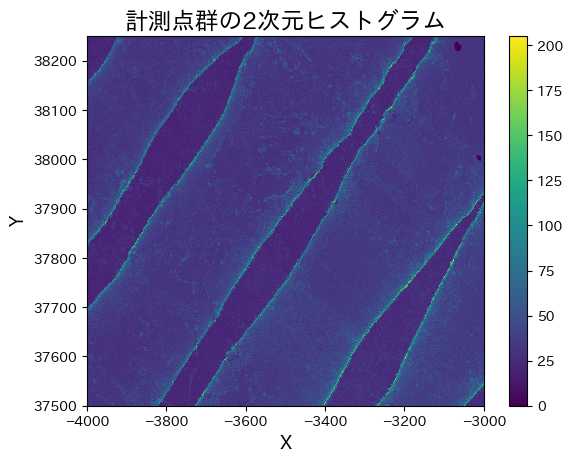

In [7]:
# セル数を適当に決める
bins = [int(v / 2) for v in (x_max - (x_min), y_max - (y_min))]

plt.hist2d(df['X'], df['Y'], bins=bins)
plt.colorbar()
plt.title('計測点群の2次元ヒストグラム', fontsize=17)
plt.xlabel('X', fontsize=13)
plt.ylabel('Y', fontsize=13);

正直2次元ヒストグラムではよくわかりませんが、平均1㎡あたり9点なので地上解像度を 0.5m 程度に設定して見ましょう。

### **各パラメーターの設定**

Intensity は最大値が 255 なので 8bit ですが、「Red」「Green」「Blue」 の方は最大値が2の16乗の範囲内なので、16bit だと推測できます。別にこのまま出力してもいいですが、使いやすいように 8bit の範囲に変換してしまいましょう。

In [8]:
# 出力ファイルのパスを設定
INTENSITY_PATH = IN_FILE.replace('proj.las', 'INTENSITY.tif')
RED_PATH = IN_FILE.replace('proj.las', 'RED.tif')
GREEN_PATH = IN_FILE.replace('proj.las', 'GREEN.tif')
BLUE_PATH = IN_FILE.replace('proj.las', 'BLUE.tif')

# 地上解像度の設定
RESOLUTION = 0.5

# 16bit の最大値を設定する
_16bit = 2**16 - 1

# 画像として出力する際の設定
write_dict = {
    'type': 'writers.gdal',
    'data_type': 'uint8',
    'resolution': RESOLUTION,
    'output_type': 'mean',
    'nodata': 0,
    'default_srs': IN_SRS,
    'gdaldriver': 'GTiff'
}

### **Pipelineの作成と実行**

In [9]:
# データの読み込み
readers = readers = pdal.Reader.las(IN_FILE)

# 16bit から 8bit への変換するタスクを構成
fassign = (
    pdal
    .Filter
    .assign(
        value=[
            f'Red = Red / {_16bit} * 255',
            f'Green = Green / {_16bit} * 255',
            f'Blue = Blue / {_16bit} * 255',
        ]
    )
)

paths = [INTENSITY_PATH, RED_PATH, GREEN_PATH, BLUE_PATH]
cols = ['Intensity', 'Red', 'Green', 'Blue']
for path, col in zip(paths, cols):
    # データを書き込むタスクを構成
    writers = (
        pdal
        .Writer(
            filename=path, 
            dimension=col, 
            **write_dict
        )
    )
    # Pipelineの作成と実行
    pipeline = readers | fassign | writers
    pipeline.execute()


これで各要素を Raster （画像）として出力する事が出来ました。

## **rasterio**
---
次は出力した Raster を読み込んで確認してみましょう。Raster の入出力や加工には `rasterio` というライブラリーを使用します。`GDAL` の方が有名かもしれませんが、python で扱うのであれば rasterio の方が簡単で、ドキュメントも読みやすいので、おススメです。

### **rasterioでのデータ入力**
まずは先ほど出力した 4枚の画像を読み込みます。

In [216]:
intensity_dst = rasterio.open(INTENSITY_PATH)

red_dst = rasterio.open(RED_PATH)

green_dst = rasterio.open(GREEN_PATH)

blue_dst = rasterio.open(BLUE_PATH)

### **RGB配列の作成**
読み込んだデータから、配列を取り出す為には`read`メソッドを使用します。RGB 画像は Red と Green 、Blue の3つのデータを使用するので、各データから配列を取り出して重ねてみます。

In [11]:
raster = np.array([
    red_dst.read(1),
    green_dst.read(1),
    blue_dst.read(1),
])

print(raster.shape)

(3, 1501, 2001)


上記で配列の形状を確認しましたが、この状態では matplotlib で表示する事が出来ません。`numpy.dstack` を使用して、配列の形状を変更しましょう。

In [12]:
img = np.dstack(raster)

print(img.shape)

(1501, 2001, 3)


### **画像の確認**
それでは上記で作成した RGB と Intensity のデータを matplotlib で表示してみます。

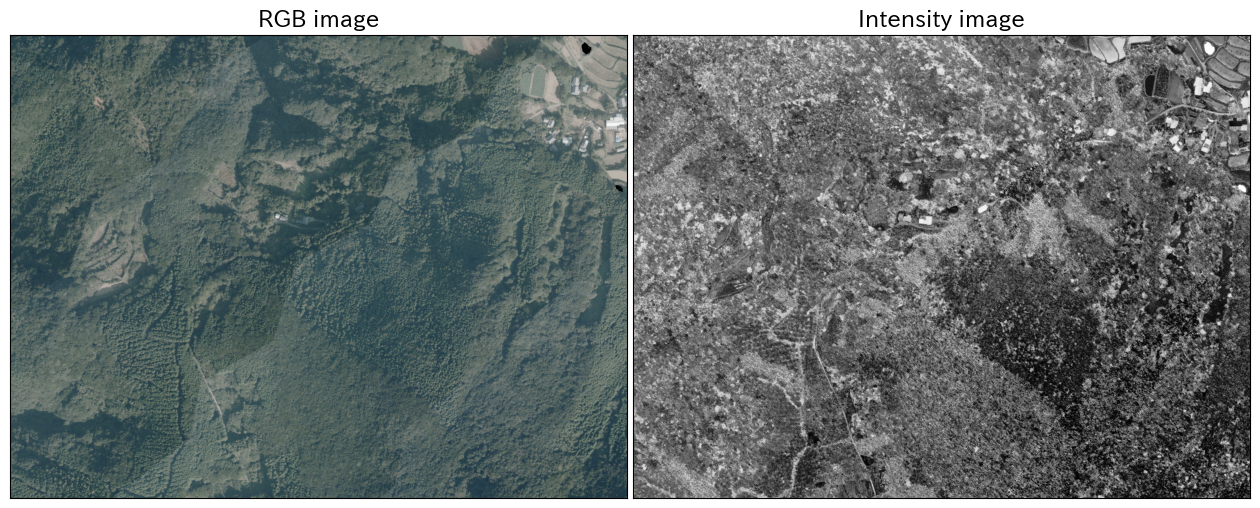

In [13]:
arys = [img, intensity_dst.read(1)]
titles = ['RGB image', 'Intensity image']

fig, ax = plt.subplots(ncols=2, figsize=(16, 10))
for _ax, ary, title in zip(ax, arys, titles):
    _ax.set_title(title, fontsize=17)
    _ax.imshow(ary, cmap='Grays')
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.01);

## **Rasterの出力**
---
一旦 RGB のオルソ画像を出力します。GISのアプリなどで使用する場合は普通に '.tif' のフォーマットで出力すると思いますが、Notebookなどで使用する場合は


## **Intensity を見てみる**
---

少し Intensity を詳しく見てみましょう。Intensity（反射強度）とは、ポイントを生成しているレーザーパルスが反射される強さを計測し、集計したものです。この数値は「スキャン角度」「粗さ」「含水率」などによって異なります。

調べてみると、反射強度の数値は絶対的な数値ではなく、相対的な数値の様です。その為、同じ場所を計測した場合であっても異なる数値が集計され、正規化された数値を記録している場合がある様です。

引用元:

[ArcGIS での LIDAR からの強度画像の作成](https://desktop.arcgis.com/ja/arcmap/latest/manage-data/las-dataset/lidar-solutions-creating-intensity-images-from-lidar.htm)

[LIDAR INTENSITY: WHAT IS IT AND WHAT ARE IT’S APPLICATIONS?](https://geodetics.com/lidar-intensity-applications/)

In [224]:
intensity_dst.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2001,
 'height': 1501,
 'count': 1,
 'crs': CRS.from_epsg(6669),
 'transform': Affine(0.5, 0.0, -4000.0,
        0.0, -0.5, 38250.5)}

In [252]:
rasterio.Affine?

Init signature: rasterio.Affine(a, b, c, d, e, f)
Docstring:     
Two dimensional affine transform for 2D linear mapping.

Parameters
----------
a, b, c, d, e, f : float
    Coefficients of an augmented affine transformation matrix

    | x' |   | a  b  c | | x |
    | y' | = | d  e  f | | y |
    | 1  |   | 0  0  1 | | 1 |

    `a`, `b`, and `c` are the elements of the first row of the
    matrix. `d`, `e`, and `f` are the elements of the second row.

Attributes
----------
a, b, c, d, e, f, g, h, i : float
    The coefficients of the 3x3 augumented affine transformation
    matrix

    | x' |   | a  b  c | | x |
    | y' | = | d  e  f | | y |
    | 1  |   | g  h  i | | 1 |

    `g`, `h`, and `i` are always 0, 0, and 1.

The Affine package is derived from Casey Duncan's Planar package.
See the copyright statement below.  Parallel lines are preserved by
these transforms. Affine transforms can perform any combination of
translations, scales/flips, shears, and rotations.  Class methods
ar

In [245]:
# metadataの書き換え
metadata = intensity_dst.meta
metadata['transform'] = rasterio.Affine(0.5, 0.0, 0.0,  0.0, 0.5, 0.0)
del metadata['crs']

# 
intensity_ary = intensity_dst.read(1)

intensity_ds = rasterio.MemoryFile().open(**intensity_dst.meta)
intensity_ds.write(intensity_ary, 1)

In [247]:
scope_1 = shapely.box(1450, 50, 1950, 450)
scope_2 = shapely.box(300, 900, 00, 1300)
poly_mask = shapely.Polygon([
    [-3650, 38200],
    [-3650, 38200],
    [-3450, 37800],
    [-3450, 37800],
])

ints_scope_1 = rasterio.mask.mask(intensity_ds, shapes=[poly_mask], crop=True)

In [244]:
intensity_ds

<open DatasetWriter name='/vsimem/1fe30b73-1137-4e5b-9977-5c9dd0a2b7d4/1fe30b73-1137-4e5b-9977-5c9dd0a2b7d4.tif' mode='w+'>

In [209]:
intensity_dst.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 2001,
 'height': 1501,
 'count': 1,
 'crs': CRS.from_epsg(6669),
 'transform': Affine(0.5, 0.0, 0.0,
        0.0, -0.5, 0.0)}

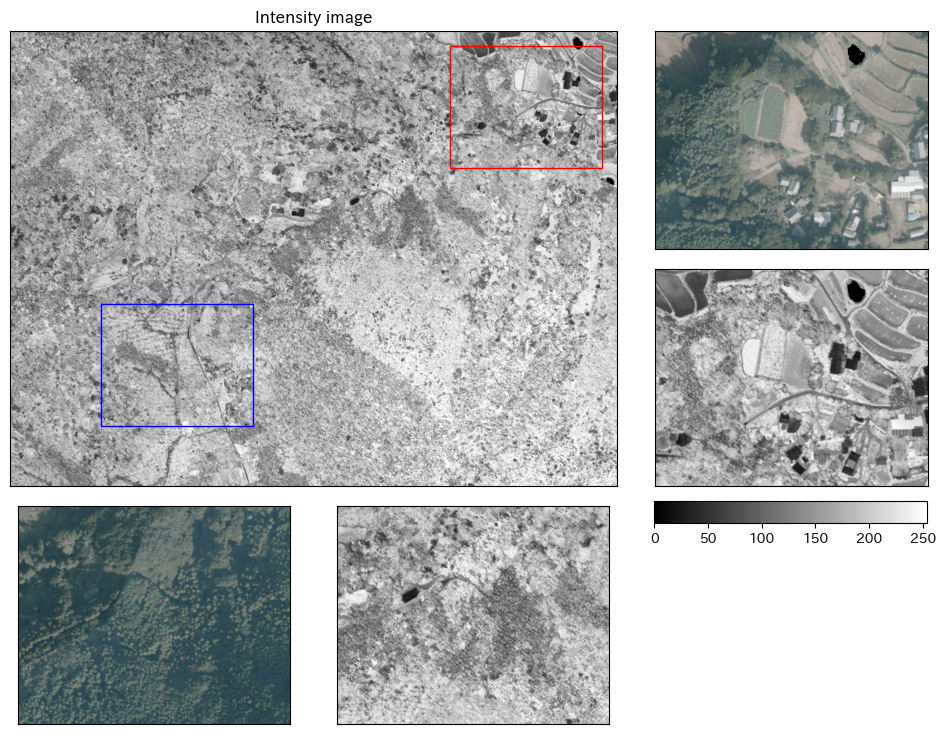

In [198]:
# 読みづらいですが、下記のコードで可視化します。
intensity = intensity_dst.read(1)

fig = plt.figure(figsize=(12, 9))
shape = (6, 6)
ax1 = plt.subplot2grid(shape, loc=(0, 0), colspan=4, rowspan=4)
ax1.set_title('Intensity image')
ax1.imshow(intensity, cmap='binary_r')
plot_polygon(scope_1, color='red', facecolor=(0, 0, 0, 0), add_points=False)
plot_polygon(scope_2, color='blue', facecolor=(0, 0, 0, 0), add_points=False)

ax2 = plt.subplot2grid(shape, loc=(0, 4), colspan=2, rowspan=2)
ax2.imshow(img[: 400, 1500:, :], cmap='binary_r')

ax3 = plt.subplot2grid(shape, loc=(2, 4), colspan=2, rowspan=2)
cb = ax3.imshow(intensity[: 400, 1500:], cmap='binary_r')

ax4 = plt.subplot2grid(shape, loc=(4, 0), rowspan=2, colspan=2)
ax4.imshow(img[400: 800, 1000: 1500])

ax5 = plt.subplot2grid(shape, loc=(4, 2), rowspan=2, colspan=2)
ax5.imshow(intensity[400: 800, 1000: 1500], cmap='binary_r')

for _ax in fig.axes:
    _ax.axes.xaxis.set_visible(False)
    _ax.axes.yaxis.set_visible(False)

cax = inset_axes(
    ax3, width='100%', height='10%', 
    bbox_to_anchor=(-0.03, -0.2, 1, 1),
    bbox_transform=ax3.transAxes, loc='lower left'
)
fig.colorbar(cb, cax=cax, orientation="horizontal");

個人的なイメージとしては、屋根や道路の方が反射率が高いかと思っていましたが、上の図を見ると逆の様です。

ため池や屋根、道路などが反射率が低く、植物の方が反射率が高いようです。

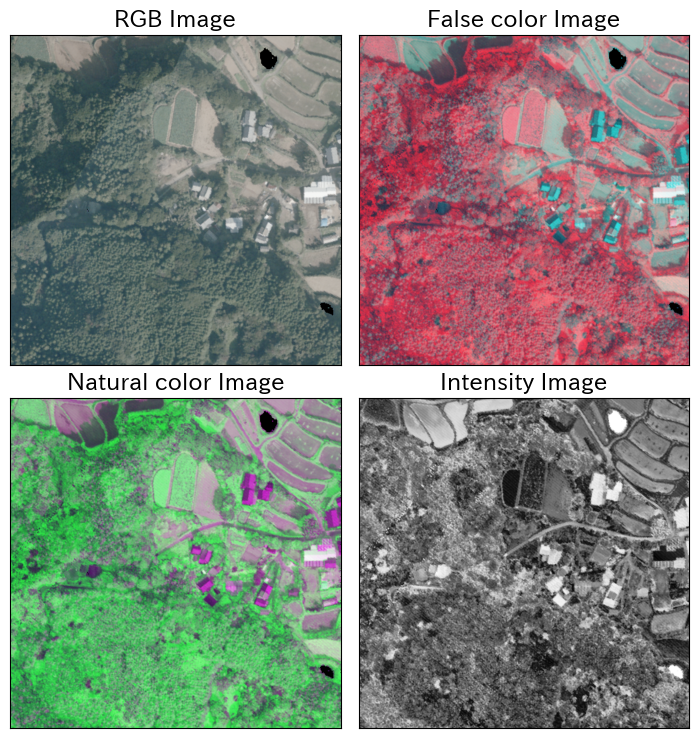

In [265]:

false_ary = np.dstack([
    intensity_dst.read(1),
    red_dst.read(1),
    green_dst.read(1)
])

natural_ary = np.dstack([
    red_dst.read(1),
    intensity_dst.read(1),
    green_dst.read(1)
])

titles = [
    'RGB Image', 'False color Image', 
    'Natural color Image', 'Intensity Image'
]
arys = [
    img, false_ary, 
    natural_ary, intensity_dst.read(1)
]


fig = plt.figure(figsize=(9, 9))
for i, (ary, title) in enumerate(zip(arys, titles)):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.set_title(title, fontsize=17)
    ax.imshow(ary[: 600, 1400:], cmap='Grays')
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0.1)

In [167]:
# meta = red_dst.meta
# meta['count'] = 3

# with rasterio.open(path, 'w', **meta) as dst:
#     for idx, _dst in enumerate([green_dst, intensity_dst, green_dst]):
#         dst.write(_dst.read(1), idx + 1)

In [29]:
intensity_dst.close()
red_dst.close()
green_dst.close()
blue_dst.close()